In [2]:
import tensorflow as tf
from tensorflow import keras
import openpyxl
from keras import layers, models
import pyarrow as pa
import pyarrow.parquet as pq
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models,callbacks
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import numpy as np
import shutil
import glob
import pandas as pd
import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score,calinski_harabasz_score, silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import os
import time
from io import StringIO
from joblib import Parallel, delayed
import pickle



os.chdir(os.path.expanduser("~/projets/pro/BIP12: Artificial Intelligence"))    #Change as needed
print(os.getcwd())
print(keras.__version__)
print(pd.__version__)
print(dask.__version__)

#Ensure reproductibility
seed=42
tf.config.experimental.enable_op_determinism()


/home/pedro/projets/pro/BIP12: Artificial Intelligence
3.12.0
2.3.3
2025.5.1


# Chargement du fichier cohort et préparation pour téléchargement

In [3]:
cohort = pd.read_excel("mmc2.xlsx")

print(cohort.head())
print(cohort.columns)

  Supplementary Table 1: The TCGA Breast Cancer Dataset (817 cases)  \
0                                                NaN                  
1                                            Case.ID                  
2                                       TCGA-BH-A18G                  
3                                       TCGA-A1-A0SP                  
4                                       TCGA-A2-A04P                  

        Unnamed: 1 Unnamed: 2   Unnamed: 3          Unnamed: 4  \
0              NaN        NaN          NaN                 NaN   
1  Final Pathology      PAM50  TumorPurity  ProliferationScore   
2              IDC      Basal         0.79            0.423067   
3              IDC      Basal         0.46            0.262933   
4              IDC      Basal          0.6            0.445335   

                     Unnamed: 5                    Unnamed: 6  \
0                           NaN                           NaN   
1                          mRNA               

/home/pedro/miniconda3/envs/keras_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:

df = pd.read_excel(
    "mmc2.xlsx",
    header=1 # ← clé : la vraie ligne d’en-têtes
)
df = df.dropna(axis=0, how='all')
df.head(5)

/home/pedro/miniconda3/envs/keras_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Mixed IDC ILC Classification,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,Case.ID,Final Pathology,PAM50,TumorPurity,ProliferationScore,mRNA,miRNA,SNP,Exome,Methylation,...,Hormone_a score,Hormone_b score,PI3K/Akt score,Ras/MAPK score,RTK score,TSC/mTOR score,ISOpure,OncoSign,ElasticNet,NaN
1,TCGA-BH-A18G,IDC,Basal,0.79,0.423067,TCGA-BH-A18G-01A-11R-A12D-07,TCGA-BH-A18G-01A-11R-A12C-13,TCGA-BH-A18G-01A-11D-A12A-01,TCGA-BH-A18G-01A-11D-A12B-09,TCGA-BH-A18G-01A-11D-A12E-05,...,-1.873243,-0.120416,-3.469006,0.94358,-1.421711,1.376493,NaN,NaN,NaN,IDC-like
2,TCGA-A1-A0SP,IDC,Basal,0.46,0.262933,TCGA-A1-A0SP-01A-11R-A084-07,TCGA-A1-A0SP-01A-11R-A085-13,TCGA-A1-A0SP-01A-11D-A087-01,TCGA-A1-A0SP-01A-11D-A099-09,TCGA-A1-A0SP-01A-11D-A10P-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ILC-like
3,TCGA-A2-A04P,IDC,Basal,0.6,0.445335,TCGA-A2-A04P-01A-31R-A034-07,TCGA-A2-A04P-01A-31R-A035-13,TCGA-A2-A04P-01A-31D-A036-01,TCGA-A2-A04P-01A-31D-A128-09,TCGA-A2-A04P-01A-31D-A032-05,...,-0.032671,-0.725427,0.990956,-0.389598,0.047441,1.079578,NaN,NaN,NaN,NaN
4,TCGA-A2-A04Q,IDC,Basal,0.17,0.189018,TCGA-A2-A04Q-01A-21R-A034-07,TCGA-A2-A04Q-01A-21R-A035-13,TCGA-A2-A04Q-01A-21D-A036-01,TCGA-A2-A04Q-01A-21W-A050-09,TCGA-A2-A04Q-01A-21D-A032-05,...,-0.114763,1.403402,-1.737561,2.117965,2.489667,-1.303777,NaN,NaN,NaN,NaN


In [5]:
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
df = df.rename(columns={"Case.ID": "Case_ID"})
df.head()


,Case_ID,Final Pathology,PAM50,TumorPurity,ProliferationScore,mRNA,miRNA,SNP,Exome,Methylation,...,Hormone_a score,Hormone_b score,PI3K/Akt score,Ras/MAPK score,RTK score,TSC/mTOR score,ISOpure,OncoSign,ElasticNet,NaN
0,TCGA-BH-A18G,IDC,Basal,0.79,0.423067,TCGA-BH-A18G-01A-11R-A12D-07,TCGA-BH-A18G-01A-11R-A12C-13,TCGA-BH-A18G-01A-11D-A12A-01,TCGA-BH-A18G-01A-11D-A12B-09,TCGA-BH-A18G-01A-11D-A12E-05,...,-1.873243,-0.120416,-3.469006,0.94358,-1.421711,1.376493,NaN,NaN,NaN,IDC-like
1,TCGA-A1-A0SP,IDC,Basal,0.46,0.262933,TCGA-A1-A0SP-01A-11R-A084-07,TCGA-A1-A0SP-01A-11R-A085-13,TCGA-A1-A0SP-01A-11D-A087-01,TCGA-A1-A0SP-01A-11D-A099-09,TCGA-A1-A0SP-01A-11D-A10P-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ILC-like
2,TCGA-A2-A04P,IDC,Basal,0.6,0.445335,TCGA-A2-A04P-01A-31R-A034-07,TCGA-A2-A04P-01A-31R-A035-13,TCGA-A2-A04P-01A-31D-A036-01,TCGA-A2-A04P-01A-31D-A128-09,TCGA-A2-A04P-01A-31D-A032-05,...,-0.032671,-0.725427,0.990956,-0.389598,0.047441,1.079578,NaN,NaN,NaN,NaN
3,TCGA-A2-A04Q,IDC,Basal,0.17,0.189018,TCGA-A2-A04Q-01A-21R-A034-07,TCGA-A2-A04Q-01A-21R-A035-13,TCGA-A2-A04Q-01A-21D-A036-01,TCGA-A2-A04Q-01A-21W-A050-09,TCGA-A2-A04Q-01A-21D-A032-05,...,-0.114763,1.403402,-1.737561,2.117965,2.489667,-1.303777,NaN,NaN,NaN,NaN
4,TCGA-A2-A04T,IDC,Basal,0.61,0.376498,TCGA-A2-A04T-01A-21R-A034-07,TCGA-A2-A04T-01A-21R-A035-13,TCGA-A2-A04T-01A-21D-A036-01,TCGA-A2-A04T-01A-21W-A050-09,TCGA-A2-A04T-01A-21D-A032-05,...,-1.576243,-1.533891,0.750345,1.040222,0.608384,-1.294638,NaN,NaN,NaN,NaN


In [6]:
print(np.unique(df["PAM50"]))

['Basal' 'Her2' 'LumA' 'LumB' 'Normal']


## Téléchargement des données RNAseq à partir des CASE ID de chaque patient dans la liste cohort

In [8]:
def download_tcga_rnaseq(case_id):
    """Télécharge les données RNAseq pour un case_id TCGA"""
    url = "https://api.gdc.cancer.gov/files"
    
    filters = {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "cases.submitter_id", "value": [case_id]}},
            {"op": "in", "content": {"field": "files.data_type", "value": ["Gene Expression Quantification"]}},
            {"op": "in", "content": {"field": "files.analysis.workflow_type", "value": ["STAR - Counts"]}}
        ]
    }
    
    params = {
        "filters": json.dumps(filters),
        "fields": "file_id,file_name,cases.submitter_id",
        "format": "JSON",
        "size": "100"
    }
    
    response = requests.get(url, params=params)
    return response.json()

# Tester avec un patient
test_case = df["Case_ID"].iloc[0]
result = download_tcga_rnaseq(test_case)
print(f"Fichiers trouvés pour {test_case}: {result['data']['pagination']['total']}")
print(result)

Fichiers trouvés pour TCGA-BH-A18G: 1
{'data': {'hits': [{'id': 'ff1f2f31-8607-4627-b487-c5e39e7c30f5', 'cases': [{'submitter_id': 'TCGA-BH-A18G'}], 'file_name': 'deb7967f-9339-4bb1-ae0b-81a72a472bba.rna_seq.augmented_star_gene_counts.tsv', 'file_id': 'ff1f2f31-8607-4627-b487-c5e39e7c30f5'}], 'pagination': {'count': 1, 'total': 1, 'size': 100, 'from': 0, 'sort': '', 'page': 1, 'pages': 1}}, 'warnings': {}}


In [9]:
# 1. Fonction pour télécharger les données d'un fichier
def download_gene_counts(file_id):
    """Télécharge le fichier de counts depuis GDC"""
    url = f"https://api.gdc.cancer.gov/data/{file_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        # Lire le TSV
        data = pd.read_csv(StringIO(response.text), sep='\t', comment='#')
        return data
    else:
        return None

# 2. Construire la matrice pour tous les patients
def build_expression_matrix(case_ids, max_patients=None):
    """
    Construit la matrice d'expression pour une liste de patients
    
    Parameters:
    -----------
    case_ids : list
        Liste des Case_ID TCGA
    max_patients : int, optional
        Limite le nombre de patients (pour tester)
    
    Returns:
    --------
    pd.DataFrame : Matrice patients × gènes
    """
    
    expression_data = {}
    failed_cases = []
    
    # Limiter si spécifié
    if max_patients:
        case_ids = case_ids[:max_patients]
    
    print(f"Téléchargement des données pour {len(case_ids)} patients...")
    
    for i, case_id in enumerate(case_ids):
        try:
            # Récupérer le file_id
            result = download_tcga_rnaseq(case_id)
            
            if result['data']['pagination']['total'] > 0:
                file_id = result['data']['hits'][0]['file_id']
                
                # Télécharger les counts
                counts = download_gene_counts(file_id)
                
                if counts is not None:
                    # Extraire les counts (colonne 'unstranded' ou 'tpm_unstranded')
                    # Adapter selon le format de vos fichiers
                    gene_counts = counts.set_index('gene_name')['unstranded']
                    expression_data[case_id] = gene_counts
                    
                    if (i + 1) % 10 == 0:
                        print(f"  Téléchargé: {i + 1}/{len(case_ids)}")
                else:
                    failed_cases.append(case_id)
            else:
                print(f"  ⚠ Pas de fichier pour {case_id}")
                failed_cases.append(case_id)
            
            # Respecter les limites de l'API
            time.sleep(0.1)
            
        except Exception as e:
            print(f"  ✗ Erreur pour {case_id}: {e}")
            failed_cases.append(case_id)
    
    # Créer le DataFrame (patients en lignes, gènes en colonnes)
    expression_matrix = pd.DataFrame(expression_data).T
    
    print(f"\n✓ Matrice construite: {expression_matrix.shape}")
    print(f"  - Patients: {expression_matrix.shape[0]}")
    print(f"  - Gènes: {expression_matrix.shape[1]}")
    if failed_cases:
        print(f"  - Échecs: {len(failed_cases)} patients")
    
    return expression_matrix, failed_cases

"""-------------------------------------------------------------"""

# 3. TESTER avec quelques patients d'abord
patients_with_rna = df[df['mRNA'].notna()]['Case_ID'].tolist()
print(f"Total patients avec mRNA: {len(patients_with_rna)}")

# TEST avec 5 patients
test_matrix, failed = build_expression_matrix(patients_with_rna, max_patients=817)


Total patients avec mRNA: 817
Téléchargement des données pour 817 patients...
  Téléchargé: 10/817
  Téléchargé: 20/817
  Téléchargé: 30/817
  Téléchargé: 40/817
  Téléchargé: 50/817
  Téléchargé: 60/817
  Téléchargé: 70/817
  Téléchargé: 80/817
  Téléchargé: 90/817
  Téléchargé: 100/817
  Téléchargé: 110/817
  Téléchargé: 120/817
  Téléchargé: 130/817
  Téléchargé: 140/817
  Téléchargé: 150/817
  Téléchargé: 160/817
  Téléchargé: 170/817
  Téléchargé: 180/817
  Téléchargé: 190/817
  Téléchargé: 200/817
  Téléchargé: 210/817
  Téléchargé: 220/817
  Téléchargé: 230/817
  Téléchargé: 240/817
  Téléchargé: 250/817
  Téléchargé: 260/817
  Téléchargé: 270/817
  Téléchargé: 280/817
  ✗ Erreur pour TCGA-C8-A1HI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
  Téléchargé: 290/817
  Téléchargé: 300/817
  Téléchargé: 310/817
  Téléchargé: 320/817
  Téléchargé: 330/817
  Téléchargé: 340/817
  Téléchargé: 350/817
  Téléchargé: 360/817
  Téléchargé: 37

Saving the resulting dataframe for future use without redownloading each time..then loading again

In [8]:
test_matrix.head(20)
test_matrix.shape

test_matrix.to_pickle("dataframe.pkl")

In [7]:
"""loading the pickled dataframe"""

test_matrix=pd.read_pickle("dataframe.pkl")

test_matrix.shape

(816, 60664)

In [9]:
# Vérifier d'abord les vrais noms des colonnes dans df
print(df.columns)
metadata_cols = ["TumorPurity", "Final Pathology", "ProliferationScore",'PAM50']

# Créer une dataframe avec les métadonnées, indexée par Case_ID
metadata = df[df['Case_ID'].isin(test_matrix.index)][['Case_ID'] + metadata_cols].set_index('Case_ID')

# Ajouter les métadonnées à test_matrix
test_matrix_with_meta = test_matrix.copy()
test_matrix_with_meta = test_matrix_with_meta.join(metadata, how='left')

print(f"Shape avant: {test_matrix.shape}")
print(f"Shape après: {test_matrix_with_meta.shape}")
print(test_matrix_with_meta.iloc[:, -5:].head())
test_matrix_with_meta.shape

Index([                  'Case_ID',           'Final Pathology',
                           'PAM50',               'TumorPurity',
              'ProliferationScore',                      'mRNA',
                           'miRNA',                       'SNP',
                           'Exome',               'Methylation',
                            'RPPA',                    'ER IHC',
                          'PR IHC',                  'HER2 IHC',
                 'Apoptosis score',          'Cell cycle score',
       'DNA damage response score',                 'EMT score',
                 'Hormone_a score',           'Hormone_b score',
                  'PI3K/Akt score',            'Ras/MAPK score',
                       'RTK score',            'TSC/mTOR score',
                        'ISOpure ',                  'OncoSign',
                      'ElasticNet',                         nan],
      dtype='object', name=0)
Shape avant: (816, 60664)
Shape après: (816, 60668)
       

(816, 60668)

## Scaling and PCA

In [10]:
test_matrix_clean=test_matrix.iloc[:,:].copy()

test_matrix_clean = test_matrix_clean.rename(columns={"Case_ID": "gene_name"})
test_matrix_clean.shape
print(test_matrix_clean.iloc[:,-3:].head())

test_matrix_clean.shape

gene_name     AC006486.3  AL391628.1  AP006621.6
TCGA-BH-A18G           0           1          23
TCGA-A1-A0SP           0           7          29
TCGA-A2-A04P           0           6          58
TCGA-A2-A04Q           0           6          23
TCGA-A2-A04T           0           3          28


(816, 60664)

In [11]:
"""Scaling the data"""

standard_scaler = StandardScaler()
data_scaled = pd.DataFrame(standard_scaler.fit_transform(test_matrix_clean.iloc[:,:]), columns=test_matrix_clean.iloc[:,:].columns, index=test_matrix_clean.index)
print(f"Data après scaling")
print(data_scaled.head())
print(data_scaled.shape)

pca=PCA(whiten=True,random_state=seed)
X_pca=pca.fit_transform(test_matrix_clean)

print("\n Data après PCA")
print(X_pca.shape)

TypeError: Feature names are only supported if all input features have string names, but your input has ['float', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

Nombre de PCs pour 85% variance: 3
Variance expliquée: 0.9069


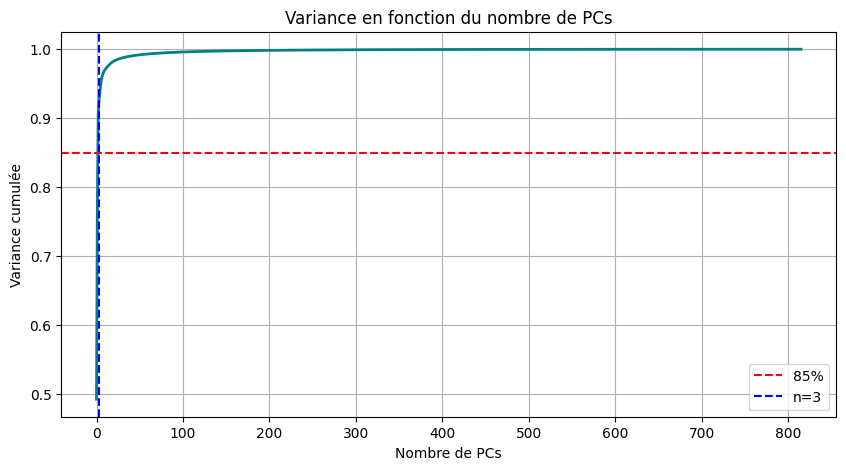

In [16]:
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composants pour 85%
n_components_85 = np.argmax(cumsum_var >= 0.85) + 1

print(f"Nombre de PCs pour 85% variance: {n_components_85}")
print(f"Variance expliquée: {cumsum_var[n_components_85-1]:.4f}")

# Visualiser
plt.figure(figsize=(10, 5))
plt.plot(cumsum_var, linewidth=2, color="teal")
plt.axhline(y=0.85, color='r', linestyle='--', label='85%')
plt.axvline(x=n_components_85, color='b', linestyle='--', label=f'n={n_components_85}')
plt.title("Variance en fonction du nombre de PCs")
plt.xlabel("Nombre de PCs")
plt.ylabel("Variance cumulée")
plt.legend()
plt.grid()
plt.show()

In [15]:
print(n_components_85)

pca_reduced=PCA(n_components=n_components_85,random_state=seed)
data_pca_reduced = pca_reduced.fit_transform(data_scaled)

print(f"Après PCA: {data_pca_reduced.shape}")  # Devrait être (300, 22)


28
Après PCA: (816, 28)


We choose 28 PCs to explain 85% of variance, this parameter will be used for the clustering approaches

Will define a class network that uses autoencoders and MLP to do the clustering

## Clustering: NN approach to the number of clusters

In this part the aim is to deploy a simple NN and have as an output the optimal nomber of clusters for the dataset, and then apply it to another NN which will handle the clustering itself
### Network class
This class has: 
- autoencoder module
- latent space encoding
- MLP module
- Metric utilization for clustering 
- Clustering analysis

In [3]:
class RNASeqNetwork:
    """
    Classe centralisée pour gérer les réseaux de neurones sur données RNAseq
    - Autoencoder pour réduction de dimensionalité
    - Clustering dans l'espace latent
    - MLP pour classification
    """
    
    def __init__(self, input_dim, seed=42):
        """
        input_dim : int
            Nombre de features en entrée
        seed : int
            Seed pour reproductibilité
        """
        self.input_dim = input_dim
        self.seed = seed
        self.encoder = None
        self.autoencoder = None
        self.mlp_classifier = None
        self.history = {}
        self.X_encoded = None
        self.labels = None
        self.n_clusters = None
        
        # Fixer les seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
        print(f"Network (input_dim={input_dim}, seed={seed})")
    
    
    def build_autoencoder(self, encoding_dim=30, hidden_layers=[128, 64],activation='relu', dropout_rate=0.2):
        """## Construit l'autoencoder:\n
        - Encoding_dim: taille du latent space,\n
        - hidden_layers: nombre de layers et de neurones par layers dans chaque côté du AE,\n
        - activation: fonction d'activation (sigmoid,softmax,linear,relu),\n
        - dropout_rate: proportion de neurones inactivés (previens overfitting)
        """
        
        # Encoder side
        input_layer = keras.layers.Input(shape=(self.input_dim,), name='input')
        x = input_layer
        
        for i, units in enumerate(hidden_layers):
            x = keras.layers.Dense(units, activation=activation, name=f'enc_dense_{i}')(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate, name=f'enc_dropout_{i}')(x)
        
        # Latent space (encoding_dim)
        encoding = keras.layers.Dense(encoding_dim, activation=activation, name='encoding')(x)
    
        # Decoder side
        x = encoding
        
        for i, units in enumerate(reversed(hidden_layers)):
            x = keras.layers.Dense(units, activation=activation, name=f'dec_dense_{i}')(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate, name=f'dec_dropout_{i}')(x)
        
        # Reconstruction
        output_layer = keras.layers.Dense(self.input_dim, activation='linear', name='output')(x)
        
        # Assemblage
        self.autoencoder = keras.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
        self.encoder = keras.Model(inputs=input_layer, outputs=encoding, name='encoder')
        
        print(f"Autoencoder construit: {self.input_dim} → {' → '.join(map(str, hidden_layers))} → {encoding_dim}")
        
        return self
    
    
    def train_autoencoder(self, X_train, epochs=50, batch_size=32,validation_split=0.2, learning_rate=0.001, verbose=1):
        """## Entraîne l'autoencoder\n
        Paramètres:
        - X_train : array-like (Données d'entraînement)
        - epochs : int (Nombre d'itérations)
        - batch_size : int (Taille des batchs)
        - validation_split : float (Proportion de validation)
        - learning_rate : float (Taux d'apprentissage)
        """
        if self.autoencoder is None:
            raise ValueError("Autoencoder non construit. Utilisez build_autoencoder() d'abord.")
        
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='mse',
            metrics=['mse']
        )
        
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=25,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=10,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        print(f"Entraînement autoencoder ({epochs} epochs max, batch={batch_size})")
        
        self.history['autoencoder'] = self.autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        print(f"Entraînement terminé (loss finale: {self.history['autoencoder'].history['val_loss'][-1]:.4f})")
        
        return self
    
    
    def encode_data(self, X):
        """### Encode les données dans l'espace latent\n
        Renvoie les données encodées si on veut utiliser uniquement l'encodeur
        #### Parameters:
        - X : array-like (Données à encoder)\n
        #### Return:
        - X_encoded : array (Données encodées)
        """
        if self.encoder is None:
            raise ValueError("Encoder non construit.")
        
        self.X_encoded = self.encoder.predict(X, verbose=0)
        print(f"Données encodées: {X.shape} → {self.X_encoded.shape}")
        
        return self.X_encoded
    
    
    def evaluate_clustering(self, X_encoded=None, max_clusters=20):
        """### Évalue plusieures métriques pour trouver le nombre optimal de clusters\n
        Utilise les métriques suivantes: 
        - Silhouette score
        - Davies-Bouldin
        - Calinski-Harabasz
        - Elbow method
        #### Paramètres: 
        - X_encoded : array-like, optional (Données encodées)
        - max_clusters : int
            (Nombre maximale de clusters à tester)
        #### Output: 
        - df_metrics : pd.DataFrame
            (Dataframe avec toutes les scores par nombre de clusters)
        """    
        if X_encoded is None:
            X_encoded = self.X_encoded
        
        if X_encoded is None:
            raise ValueError("Pas de données encodées. Utilisez encode_data() d'abord.")
        
        K_range = range(2, min(max_clusters + 1, len(X_encoded)))
        metrics_results = {
            'n_clusters': [],
            'silhouette': [],
            'davies_bouldin': [],
            'calinski_harabasz': [],
            'Elbow': []
        }
        
        print(f"Évaluation de {len(K_range)} configurations de clusters")
        
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=self.seed, n_init=10)
            labels = kmeans.fit_predict(X_encoded)
            
            # Silhouette
            silhouette = silhouette_score(X_encoded, labels)
            
            # Davies-Bouldin
            davies_bouldin = davies_bouldin_score(X_encoded, labels)
            
            # Calinski-Harabasz
            calinski = calinski_harabasz_score(X_encoded, labels)
            
            # Elbow method
            inertia = kmeans.inertia_
            
            metrics_results['n_clusters'].append(k)
            metrics_results['silhouette'].append(silhouette)
            metrics_results['davies_bouldin'].append(davies_bouldin)
            metrics_results['calinski_harabasz'].append(calinski)
            metrics_results['Elbow'].append(inertia)
        
        self.df_metrics = pd.DataFrame(metrics_results)
        
        print("C'est fini :)")
        print("\nRésumé des métriques:")
        print(self.df_metrics)
    
        return self.df_metrics


    def plot_metrics_comparison(self):
        """
        Visualise toutes les métriques utilisées par evaluate_clustering pour les comparer entre eux

        """
        if not hasattr(self, 'df_metrics'):
            print("Scores non trouvés. Utilisez evaluate_clustering d'abord.")
            return
        
        df = self.df_metrics
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Comparaison des métriques de clustering', fontsize=16, fontweight='bold')
        
        # Silhouette 
        ax = axes[0, 0]
        ax.plot(df['n_clusters'], df['silhouette'], marker='o', linewidth=2.5, 
                markersize=8, color='teal', label='Silhouette')
        best_silhouette_idx = df['silhouette'].idxmax()
        ax.scatter(df.loc[best_silhouette_idx, 'n_clusters'], 
                df.loc[best_silhouette_idx, 'silhouette'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_silhouette_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title('Silhouette Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.05, f"Max: {df.loc[best_silhouette_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_silhouette_idx, 'silhouette']:.3f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Davies-Bouldin
        ax = axes[0, 1]
        ax.plot(df['n_clusters'], df['davies_bouldin'], marker='s', linewidth=2.5, 
                markersize=8, color='coral', label='Davies-Bouldin')
        best_db_idx = df['davies_bouldin'].idxmin()
        ax.scatter(df.loc[best_db_idx, 'n_clusters'], 
                df.loc[best_db_idx, 'davies_bouldin'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_db_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Index', fontsize=11)
        ax.set_title('Davies-Bouldin Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.95, f"Min: {df.loc[best_db_idx, 'n_clusters']:.0f} clusters\n"
                            f"Index: {df.loc[best_db_idx, 'davies_bouldin']:.3f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 3. Calisnki-Harabasz
        ax = axes[1, 0]
        ax.plot(df['n_clusters'], df['calinski_harabasz'], marker='^', linewidth=2.5, 
                markersize=8, color='orange', label='Calinski-Harabasz')
        best_ch_idx = df['calinski_harabasz'].idxmax()
        ax.scatter(df.loc[best_ch_idx, 'n_clusters'], 
                df.loc[best_ch_idx, 'calinski_harabasz'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_ch_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title('Calinski-Harabasz Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.05, f"Max: {df.loc[best_ch_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_ch_idx, 'calinski_harabasz']:.1f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Elbow method
        ax = axes[1, 1]
        ax.plot(df['n_clusters'], df['Elbow'], marker='d', linewidth=2.5, 
                markersize=8, color='green')
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Inertia', fontsize=11)
        ax.set_title('Elbow Method', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Bilan
        print("")
        print(f"Silhouette Score optimal:{df.loc[best_silhouette_idx, 'n_clusters']:.0f} clusters")
        print(f"Davies-Bouldin optimal:{df.loc[best_db_idx, 'n_clusters']:.0f} clusters")
        print(f"Calinski-Harabasz optimal:{df.loc[best_ch_idx, 'n_clusters']:.0f} clusters")

    def cluster_data(self, X_encoded=None, n_clusters=None):
        """### Effectue le clustering sur les données\n
        #### Paramètres: 
        - X_encoded : array-like, optional
            (Données encodées)
        - n_clusters : int, optional
            (à utiliser si n_clusters est None)
        
        #### Return:
        - labels : array
            (Labels de clusters)
        """        
        if X_encoded is None:
            X_encoded = self.X_encoded
        
        if n_clusters is None:
            n_clusters = self.n_clusters
        
        if n_clusters is None:
            raise ValueError("Nombre de clusters non défini. Utilisez find_optimal_clusters().")
        
        print(f"Clustering avec {n_clusters} clusters")
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=self.seed, n_init=20)
        self.labels = self.kmeans.fit_predict(X_encoded)
        
        unique, counts = np.unique(self.labels, return_counts=True)
        print(f"Distribution des clusters:")
        for cluster_id, count in zip(unique, counts):
            print(f"Cluster {cluster_id}: {count} échantillons ({100*count/len(self.labels):.1f}%)")
        
        return self.labels
    
    
    def build_mlp_classifier(self, n_classes, hidden_layers=[64, 32], 
                            activation='relu', dropout_rate=0.3):
        """### Construit un MLP pour classification\n

        #### Paramètres:        
        - n_classes : int
            (Nombre de classes)
        - hidden_layers : list
            (Tailles et nombre de hidden layers) 
        - activation : str
            (Fonction d'activation utilisée: 
            - sigmoid, softmax, linear)
        - dropout_rate : float
            (Taux de dropout)
        """        
        mlp_layers = [layers.InputLayer(input_shape=(self.X_encoded.shape[1],))]
        
        for units in hidden_layers:
            mlp_layers.append(layers.Dense(units, activation=activation))
            if dropout_rate > 0:
                mlp_layers.append(layers.Dropout(dropout_rate))
        
        mlp_layers.append(layers.Dense(n_classes, activation='softmax'))
        
        self.mlp_classifier = models.Sequential(mlp_layers, name='mlp_classifier')
        
        print(f"MLP construit: {self.X_encoded.shape[1]} → {' → '.join(map(str, hidden_layers))} → {n_classes}")
        
        return self
    
    
    def train_mlp_classifier(self, y_train, epochs=50, batch_size=32, 
                            validation_split=0.2, learning_rate=0.001,early_stop=True, verbose=1):
        """### Entraîne le MLP classifier\n
        #### Paramètres:
        - y_train : array-like
            (Labels d'entraînement)
        - epochs : int
            (Nombre d'itérations)
        - batch_size : int
            (Taille des batchs)
        - validation_split : float
            (Proportion de validation)
        - learning_rate : float
            (Taux d'apprentissage)
        - early_stop: bool
            (True pour utiliser EarlyStopping et ReduceLROnPlateau)
        """
        if self.mlp_classifier is None:
            raise ValueError("MLP non construit. Utilisez build_mlp_classifier() d'abord.")
        
        
        self.mlp_classifier.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        if early_stop==True:
            early_stopping = EarlyStopping(
            monitor='val_loss',           # Métrique à surveiller
            patience=25,                  # Nombre d'epochs à attendre sans amélioration
            restore_best_weights=True,    # Restaurer les meilleurs poids
            verbose=1                     # Afficher les messages
        )
            reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,                   # Multiplier le LR par 0.2
            patience=10,                   # Attendre 5 époques
            min_lr=1e-7,                # LR minimum
            verbose=1
        )
            print(f"Entraînement MLP ({epochs} epochs max) avec callbacks")
            
            self.history['mlp'] = self.mlp_classifier.fit(
                self.X_encoded, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                callbacks=[early_stopping,reduce_lr],
                verbose=verbose
            )
        else:
            print(f"Entraînement MLP ({epochs} epochs max)")
            
            self.history['mlp'] = self.mlp_classifier.fit(
                self.X_encoded, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                verbose=verbose
            )
        
        print(f"Entraînement terminé (accuracy: {self.history['mlp'].history['val_accuracy'][-1]:.4f})")
        
        return self
    
    
    def plot_training_history(self):
        """### Visualise l'historique d'entraînement\n
        Renvoie une représentation graphique du Loss et Accuracy au cours des itérations d'entrainement du MLP
        """
        n_plots = len(self.history)
        
        if n_plots == 0:
            print("Aucun historique d'entraînement disponible.")
            return
        
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
        if n_plots == 1:
            axes = [axes]
        
        for idx, (model_name, hist) in enumerate(self.history.items()):
            ax = axes[idx]
            
            if 'loss' in hist.history:
                ax.plot(hist.history['loss'], label='Train Loss')
                ax.plot(hist.history['val_loss'], label='Val Loss')
                ax.set_ylabel('Loss')
            
            if 'accuracy' in hist.history:
                ax2 = ax.twinx()
                ax2.plot(hist.history['accuracy'], label='Train Acc', linestyle='--', color='green')
                ax2.plot(hist.history['val_accuracy'], label='Val Acc', linestyle='--', color='orange')
                ax2.set_ylabel('Accuracy')
                
                # Combiner les légendes des deux axes
                lines1, labels1 = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
                #ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

            else:
                ax.legend(loc='best')
            
            ax.set_xlabel('Epoch')
            ax.set_title(f'{model_name.upper()} Training')
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    
    def select_optimal_clusters_advanced(self, strategy='normalized_vote'):
        """Sélectionne le nombre optimal de clusters avec vote pondéré et normalisé
        ## Paramètres:
        
        - strategy : str
            'normalized_vote' : vote pondéré après normalisation [0,1]
            'z-score'         : z-score voting (plus robuste aux outliers)
            'simple_vote'    : vote simple majoritaire
        ## Returns: 
            'n_optimal': (Nombre de clusters optimal, int)
        """
        if not hasattr(self, 'df_metrics'):
            raise ValueError("Pas de métriques. Utilisez evaluate_clustering() d'abord.")
        
        df = self.df_metrics.copy()
        
        # Normaliser chaque métrique entre 0 et 1 (où 1 = optimal)
        df['silhouette_norm'] = (df['silhouette'] - df['silhouette'].min()) / (df['silhouette'].max() - df['silhouette'].min())
        
        # Davies-Bouldin : il faut inverser (plus petit = meilleur)
        df['davies_norm'] = 1 - (df['davies_bouldin'] - df['davies_bouldin'].min()) / (df['davies_bouldin'].max() - df['davies_bouldin'].min())
        
        df['calinski_norm'] = (df['calinski_harabasz'] - df['calinski_harabasz'].min()) / (df['calinski_harabasz'].max() - df['calinski_harabasz'].min())
        
        # Elbow : normaliser inverse (plus petit = meilleur)
        df['elbow_norm'] = 1 - (df['Elbow'] - df['Elbow'].min()) / (df['Elbow'].max() - df['Elbow'].min())
        
        if strategy == 'normalized_vote':
            # Score moyen normalisé
            df['ensemble_score'] = (df['silhouette_norm'] + df['davies_norm'] + 
                                df['calinski_norm'] + df['elbow_norm']) / 4
            
            best_idx = df['ensemble_score'].idxmax()
            n_optimal = df.loc[best_idx, 'n_clusters']
            
            print("Ensemble Voting (Normalized):")
            print(f"  Silhouette score:     {df.loc[best_idx, 'silhouette_norm']:.3f}")
            print(f"  Davies-Bouldin:       {df.loc[best_idx, 'davies_norm']:.3f}")
            print(f"  Calinski-Harabasz:    {df.loc[best_idx, 'calinski_norm']:.3f}")
            print(f"  Elbow:                {df.loc[best_idx, 'elbow_norm']:.3f}")
            print(f"  Ensemble Score: {df.loc[best_idx, 'ensemble_score']:.3f}")
            print(f"\nDonc {n_optimal} clusters recommandés\n")
            
            # Afficher le top 3
            print("Top 3 recommandations:")
            top3 = df.nlargest(3, 'ensemble_score')[['n_clusters', 'ensemble_score']]
            for idx, row in top3.iterrows():
                print(f"  {row['n_clusters']:.0f} clusters → score {row['ensemble_score']:.3f}")
        
        elif strategy == 'zscore':
            # Z-score voting (robuste aux outliers)
            from scipy import stats
            df['silhouette_z'] = np.abs(stats.zscore(df['silhouette_norm']))
            df['davies_z'] = np.abs(stats.zscore(df['davies_norm']))
            df['calinski_z'] = np.abs(stats.zscore(df['calinski_norm']))
            df['elbow_z'] = np.abs(stats.zscore(df['elbow_norm']))
            
            # Plus bas Z-score = plus proche de la moyenne des bonnes métriques
            df['ensemble_score'] = df['silhouette_z'] + df['davies_z'] + df['calinski_z'] + df['elbow_z']
            best_idx = df['ensemble_score'].idxmin()
            n_optimal = df.loc[best_idx, 'n_clusters']
            
            print(f"Z-Score Voting → {n_optimal} clusters")
        
        self.n_clusters = n_optimal
        return n_optimal


    def plot_ensemble_voting(self):
        """Visualise le score d'ensemble"""
        if not hasattr(self, 'df_metrics'):
            print("Pas de métriques. Utilisez evaluate_clustering() d'abord.")
            return
        
        df = self.df_metrics.copy()
        
        # Normaliser les métriques
        df['silhouette_norm'] = (df['silhouette'] - df['silhouette'].min()) / (df['silhouette'].max() - df['silhouette'].min())
        df['davies_norm'] = 1 - (df['davies_bouldin'] - df['davies_bouldin'].min()) / (df['davies_bouldin'].max() - df['davies_bouldin'].min())
        df['calinski_norm'] = (df['calinski_harabasz'] - df['calinski_harabasz'].min()) / (df['calinski_harabasz'].max() - df['calinski_harabasz'].min())
        df['elbow_norm'] = 1 - (df['Elbow'] - df['Elbow'].min()) / (df['Elbow'].max() - df['Elbow'].min())
        df['ensemble_score'] = (df['silhouette_norm'] + df['davies_norm'] + df['calinski_norm'] + df['elbow_norm']) / 4
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Gauche : toutes les métriques normalisées
        ax1.plot(df['n_clusters'], df['silhouette_norm'], marker='o', label='Silhouette (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['davies_norm'], marker='s', label='Davies-Bouldin (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['calinski_norm'], marker='^', label='Calinski-Harabasz (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['elbow_norm'], marker='d', label='Elbow (norm)', linewidth=2)
        ax1.set_xlabel('Nombre de clusters', fontsize=11)
        ax1.set_ylabel('Score normalisé [0, 1]', fontsize=11)
        ax1.set_title('Métriques Normalisées (0=pire, 1=meilleur)', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Droite : ensemble voting
        best_idx = df['ensemble_score'].idxmax()
        ax2.plot(df['n_clusters'], df['ensemble_score'], marker='o', linewidth=3, 
                color='coral', markersize=10, label='Ensemble Score')
        ax2.scatter(df.loc[best_idx, 'n_clusters'], df.loc[best_idx, 'ensemble_score'],
                color='red', s=400, marker='*', zorder=5, label=f"Optimal: {df.loc[best_idx, 'n_clusters']:.0f}")
        ax2.axvline(x=df.loc[best_idx, 'n_clusters'], color='red', linestyle='--', alpha=0.5)
        ax2.fill_between(df['n_clusters'], df['ensemble_score'], alpha=0.3, color='red')
        ax2.set_xlabel('Nombre de clusters', fontsize=11)
        ax2.set_ylabel('Score Ensemble (moyenne)', fontsize=11)
        ax2.set_title('Ensemble Voting Score', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.text(0.98, 0.05, f"Meilleur: {df.loc[best_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_idx, 'ensemble_score']:.3f}",
                transform=ax2.transAxes, fontsize=11, verticalalignment='bottom',
                horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_cluster_analysis(self):
        """### Visualise les résultats de clustering\n
        Renvoie: 
        - Barplot de la distribution des données dans chaque cluster
        - Représentation TSNE des données annotée par cluster
        """
        if self.labels is None:
            print("Pas de labels de clustering disponibles.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        # 1. Distribution des clusters
        unique, counts = np.unique(self.labels, return_counts=True)
        ax1.bar(unique, counts, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Cluster ID')
        ax1.set_ylabel('Nombre d\'échantillons')
        ax1.set_title('Distribution des clusters')
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. t-SNE visualization
        tsne = TSNE(n_components=2, random_state=self.seed, perplexity=min(30, len(self.X_encoded)-1))
        X_tsne = tsne.fit_transform(self.X_encoded)
        
        scatter = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.labels, cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
        ax2.set_xlabel('t-SNE 1')
        ax2.set_ylabel('t-SNE 2')
        ax2.set_title('Visualisation t-SNE des clusters')
        plt.colorbar(scatter, ax=ax2, label='Cluster')
        
        plt.tight_layout()
        plt.show()
    
    
    def save_models(self, path_prefix='models/rnaseq'):
        """Sauvegarde les modèles"""
        os.makedirs(os.path.dirname(path_prefix) if os.path.dirname(path_prefix) else '.', exist_ok=True)
        
        if self.encoder:
            self.encoder.save(f'{path_prefix}_encoder.keras')
            print(f"Encoder sauvegardé: {path_prefix}_encoder.keras")
        
        if self.autoencoder:
            self.autoencoder.save(f'{path_prefix}_autoencoder.keras')
            print(f"Autoencoder sauvegardé: {path_prefix}_autoencoder.keras")
        
        if self.mlp_classifier:
            self.mlp_classifier.save(f'{path_prefix}_mlp.keras')
            print(f"MLP sauvegardé: {path_prefix}_mlp.keras")
    
    
    def summary(self):
        """Affiche un résumé de l'état du réseau"""
        print("\nBilan Network")
        print("")
        print(f"Input dimension: {self.input_dim}")
        print(f"Seed: {self.seed}")
        
        if self.encoder:
            print(f"\nEncoder: {self.encoder.output_shape[-1]} dimensions latentes")
            print("")
            print(self.autoencoder.summary())
        
        if self.X_encoded is not None:
            print(f"Données encodées: {self.X_encoded.shape}")
        
        if self.n_clusters:
            print(f"Clustering: {self.n_clusters} clusters")
        
        if self.mlp_classifier:
            print(f"MLP Classifier construit")
            print("")
            print(self.mlp_classifier.summary())
        

## Usage of Class


In [4]:
"""Initialisation de la classe"""
network = RNASeqNetwork(input_dim=data_scaled.shape[1], seed=seed)


NameError: name 'data_scaled' is not defined

Autoencoder construit: 60664 → 1024 → 512 → 64
Entraînement autoencoder (300 epochs max, batch=32)
Epoch 1/300


2026-01-05 21:30:51.810733: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.8780 - mse: 0.8780

2026-01-05 21:31:02.796373: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - loss: 0.8557 - mse: 0.8557 - val_loss: 1.1169 - val_mse: 1.1169 - learning_rate: 5.0000e-04
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 623ms/step - loss: 0.9327 - mse: 0.9327 - val_loss: 1.2371 - val_mse: 1.2371 - learning_rate: 5.0000e-04
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 470ms/step - loss: 0.8162 - mse: 0.8162 - val_loss: 1.1554 - val_mse: 1.1554 - learning_rate: 5.0000e-04
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step - loss: 0.9049 - mse: 0.9049 - val_loss: 1.1567 - val_mse: 1.1567 - learning_rate: 5.0000e-04
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 444ms/step - loss: 0.7438 - mse: 0.7438 - val_loss: 1.0599 - val_mse: 1.0599 - learning_rate: 5.0000e-04
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - loss: 0.7220 - mse: 0.7220 - val_loss: 1.1161 - val_mse: 1.1161 - learning_rate: 5.0000e-04
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - loss: 0.7423 - mse: 0.7423 - val_loss: 1.1801 - val_mse: 1.1801 - le

2026-01-05 21:38:44.458505: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (816, 60664) → (816, 64)
Évaluation de 49 configurations de clusters
C'est fini :)

Résumé des métriques:
    n_clusters  silhouette  davies_bouldin  calinski_harabasz       Elbow
0            2    0.169852        2.470214         103.952965  27932688.0
1            3    0.155945        2.188578          87.610840  25914624.0
2            4    0.150870        2.025967          82.117851  24167626.0
3            5    0.155682        1.838639          77.883347  22757802.0
4            6    0.121499        1.811170          74.679382  21560724.0
5            7    0.127055        1.610779          73.715416  20365658.0
6            8    0.091386        1.680540          70.746742  19529898.0
7            9    0.100329        1.710166          66.434105  18992086.0
8           10    0.095332        1.673955          64.257507  18340368.0
9           11    0.091454        1.744860          59.536854  18107658.0
10          12    0.098872        1.661547          58.743580 

/tmp/ipykernel_68415/4272791755.py:285: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


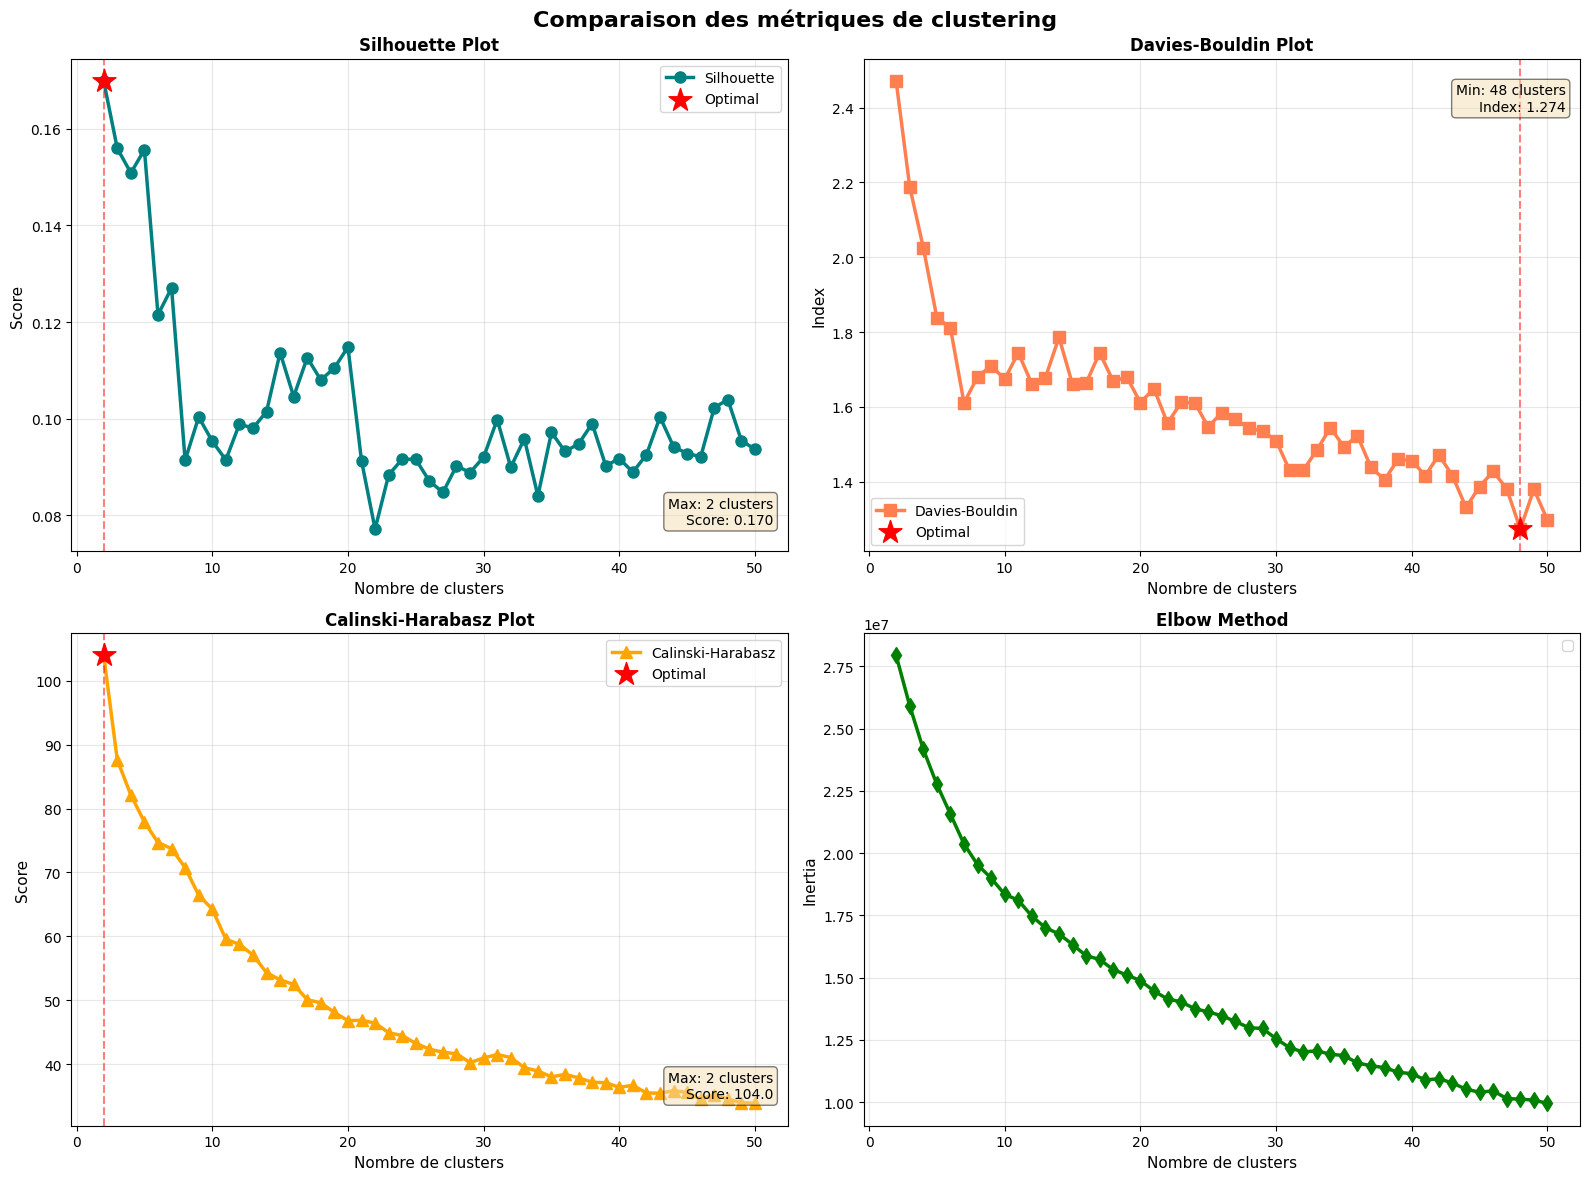


Silhouette Score optimal:2 clusters
Davies-Bouldin optimal:48 clusters
Calinski-Harabasz optimal:2 clusters
Ensemble Voting (Normalized):
  Silhouette score:     0.847
  Davies-Bouldin:       0.528
  Calinski-Harabasz:    0.628
  Elbow:                0.288
  Ensemble Score: 0.573

Donc 5 clusters recommandés

Top 3 recommandations:
  5 clusters → score 0.573
  48 clusters → score 0.572
  7 clusters → score 0.562


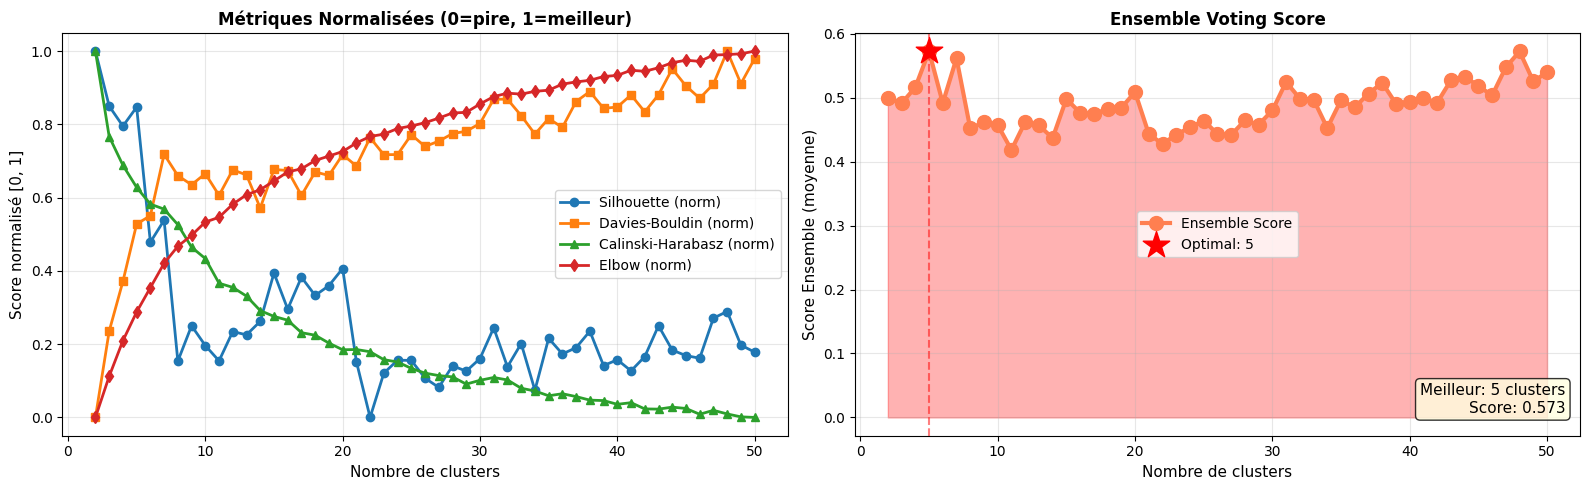

Clustering avec 5 clusters
Distribution des clusters:
Cluster 0: 230 échantillons (28.2%)
Cluster 1: 58 échantillons (7.1%)
Cluster 2: 371 échantillons (45.5%)
Cluster 3: 91 échantillons (11.2%)
Cluster 4: 66 échantillons (8.1%)

Plot training history



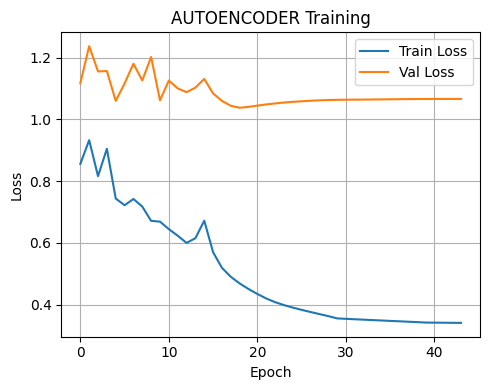

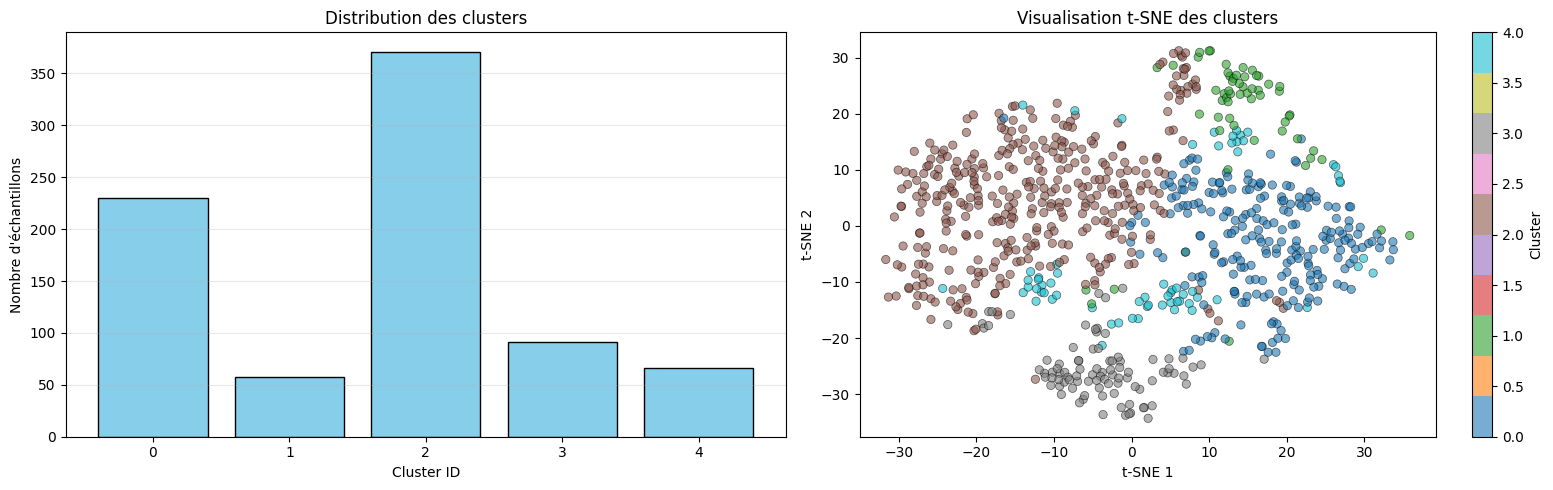

Encoder sauvegardé: models/rnaseq_tuning_encoder.keras
Autoencoder sauvegardé: models/rnaseq_tuning_autoencoder.keras

Bilan Network

Input dimension: 60664
Seed: 42

Encoder: 64 dimensions latentes



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60664)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_0 (Dense)             │ (None, 1024)           │    62,120,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_0 (Dense)             │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 60664)          │    62,180,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 376,253,354 (1.40 GB)

 Trainable params: 125,417,784 (478.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 250,835,570 (956.86 MB)

None
Données encodées: (816, 64)
Clustering: 5 clusters


In [24]:
"""Autoencoder and latent space encoding"""
network.build_autoencoder(
    encoding_dim=64,
    activation="relu",
    hidden_layers=[1024, 512],
    dropout_rate=0.0
)
network.train_autoencoder(
    X_train=data_scaled,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    learning_rate=5e-4
)
network.encode_data(data_scaled)

"""Clustering"""

network.evaluate_clustering(max_clusters=50)
network.plot_metrics_comparison()
network.select_optimal_clusters_advanced(strategy='normalized_vote') #Choisir entre normalized, z-score or simple-vote
network.plot_ensemble_voting()
network.cluster_data()
# Visualiser
print("\nPlot training history\n")
network.plot_training_history()
network.plot_cluster_analysis()

"""Sauvegarde et Bilan"""
network.save_models('models/rnaseq_tuning')
network.summary()

In [30]:
print(f"Debugging\n")

print(f"data_scaled shape: {data_scaled.shape}")
print(f"network.input_dim: {network.input_dim}")
print("\nStatistiques du réseau:\n")
print(f"Min: {data_scaled.min().min():.4f}")
print(f"Max: {data_scaled.max().max():.4f}")

print(f"Mean: {data_scaled.mean().mean():.4f}")
print(f"Std: {data_scaled.std().mean():.4f}")
print("\nsi mean~0 et std~1, alors MSE et relu sont bien adaptés, sinon chercher autrement\n")

print(f"NaN: {data_scaled.isna().sum().sum()}")
print(f"Inf: {np.isinf(data_scaled.values).sum()}")

Debugging

data_scaled shape: (816, 60664)
network.input_dim: 60664

Statistiques du réseau:

Min: -2.8822
Max: 28.5482
Mean: -0.0000
Std: 0.9547

si mean~0 et std~1, alors MSE et relu sont bien adaptés, sinon chercher autrement

NaN: 0
Inf: 0


In [29]:
print(network.X_encoded.shape)
print(network.labels)
print(f"nombre de clusters trouvés: {len(np.unique(network.labels))}")

(816, 64)
[2 3 2 2 3 2 2 3 3 2 3 3 2 3 3 3 4 3 4 4 3 3 3 2 1 2 2 3 3 3 3 3 3 2 3 2 3
 3 2 3 2 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3 1 2 4 3 3 1 1 1 3 3 2 3 3 3 3 3 2
 3 3 3 3 3 3 3 3 3 2 3 3 2 4 2 2 3 2 3 4 3 1 2 3 3 3 3 4 3 2 4 2 3 4 2 2 4
 4 2 2 2 0 0 2 2 1 2 0 2 4 2 0 1 0 2 2 0 2 2 2 4 2 2 3 2 2 3 0 0 3 0 2 0 2
 3 2 2 3 3 2 0 2 0 2 4 2 2 2 2 2 2 2 2 4 2 2 0 0 2 0 2 2 2 2 0 0 0 2 0 0 0
 1 0 2 1 0 0 2 2 0 0 2 0 1 0 2 0 2 0 0 4 2 2 0 2 0 0 2 2 2 2 0 2 0 0 0 2 0
 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 2 0 2 2 2 2 2 0 2 0 1 1 2 0 2 0 1 2 2 0 4 2 2 4 2 0 0 2 2 2 0 0 2 0 2 2 0
 0 0 2 4 0 0 0 2 2 2 2 0 0 2 2 2 4 4 0 2 2 0 2 2 0 2 2 0 1 2 0 2 2 0 0 2 0
 0 2 0 0 1 0 0 0 0 0 2 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 4 0 2 4 2 0 2 0 0
 0 0 2 2 0 0 0 0 4 0 2 0 2 2 0 0 1 0 0 0 0 0 2 0 0 0 2 4 2 0 1 0 2 0 0 0 0
 0 0 4 2 2 2 0 0 2 2 2 2 0 2 0 4 2 2 2 1 0 0 1 0 1 2 2 2 2 0 0 0 0 0 0 0 0
 0 0 2 2 4 0 0 0 2 4 2 0 0 2 2 0 2 2 2 2 2 2 2 0 0 0 0 4 0 0 0 1 2 4 4 4 2
 1 4 2 1 3 2 2 

In [1]:
"""Classification"""
# Si tu as des labels (ex: metadata['Final Pathology'])
network.encode_data(data_scaled)
network.build_mlp_classifier(
    n_classes=len(np.unique(network.labels)),  # adapte selon tes labels
    hidden_layers=[64, 32],
    activation="sigmoid",
    dropout_rate=0.1
).train_mlp_classifier(
    y_train=network.labels,  # LabelEncoder sur tes metadata
    epochs=200,
    validation_split=0.2,
    learning_rate=5e-4
)
network.plot_training_history()
network.summary()


NameError: name 'network' is not defined